In [1]:
import tensorflow as tf
import numpy as np
import os
import pandas as pd
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from cryptovision.tools import image_directory_to_pandas, split_image_dataframe, tf_dataset_from_pandas


2024-12-17 18:11:16.348 | INFO     | cryptovision.config:<module>:15 - PROJ_ROOT path is: /Users/leonardo/Documents/Projects/cryptovision


In [2]:
IMAGES_DATASET_PATH = '/Users/leonardo/Documents/Projects/cryptovision/data/processed/cv_images_dataset'
TRAINED_MODEL_PATH = '/Users/leonardo/Documents/Projects/cryptovision/models/phorcys_v09_hacpl_rn50v2_v2411251155.keras'

SEED = 42
VAL_SIZE = 0.15
TEST_SIZE = 0.15
BATCH_SIZE = 64

df_images = image_directory_to_pandas(IMAGES_DATASET_PATH)

train_df, val_df, test_df = split_image_dataframe(
    df_images,
    val_size=VAL_SIZE,
    test_size=TEST_SIZE,
    random_state=SEED,
)

test_df.reset_index(drop=True, inplace=True)

family_labels = sorted(df_images['family'].unique())
genus_labels = sorted(df_images['genus'].unique())
species_labels = sorted(df_images['species'].unique())

test_ds, _, _, _ = tf_dataset_from_pandas(
    test_df, 
    batch_size=BATCH_SIZE, 
    image_size=(384, 384), 
    shuffle=False
)


2024-12-17 18:11:16.698321: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-12-17 18:11:16.698342: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2024-12-17 18:11:16.698347: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2024-12-17 18:11:16.698359: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-17 18:11:16.698368: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
import tensorflow as tf
import numpy as np
import os
import pandas as pd
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
import matplotlib.pyplot as plt
from tqdm import tqdm
from lime import lime_image
from skimage.segmentation import mark_boundaries
from lime.lime_image import LimeImageExplainer

class CryptoVisionAI:
    def __init__(self, model_path, family_names, genus_names, species_names):
        """
        Initialize the CryptoVisionAI class.
        """
        self.model = tf.keras.models.load_model(model_path)
        self.family_names = family_names
        self.genus_names = genus_names
        self.species_names = species_names
        self.input_size = self.model.input_shape[1:3]
        self._image = None
        self._image_array = None

    @property
    def family_model(self):
        return tf.keras.Model(inputs=self.model.input, outputs=self.model.get_layer('family').output)

    @property
    def genus_model(self):
        return tf.keras.Model(inputs=self.model.input, outputs=self.model.get_layer('genus').output)

    @property
    def species_model(self):
        return tf.keras.Model(inputs=self.model.input, outputs=self.model.get_layer('species').output)

    @property
    def image(self):
        return self._image

    @property
    def image_array(self):
        return self._image_array

    @property
    def confidence(self):
        try:
            family_pred = self.preds[0].max() if self.preds[0] is not None else "Unknown"
            genus_pred = self.preds[1].max() if self.preds[1] is not None else "Unknown"
            species_pred = self.preds[2].max() if self.preds[2] is not None else "Unknown"
            return (family_pred, genus_pred, species_pred)
        except IndexError:
            return ("Unknown", "Unknown", "Unknown")
    
    def load_image(self, image_path):
        """
        Load and preprocess an image for prediction.
        """
        self._image = tf.keras.utils.load_img(image_path, target_size=self.input_size)
        img_array = tf.keras.utils.img_to_array(self._image)
        self._image_array = np.expand_dims(img_array, axis=0)
        return self._image_array

    def decoder(self, preds):
        try:
            family_pred = self.family_names[np.argmax(preds[0])] if preds[0] is not None else "Unknown"
            genus_pred = self.genus_names[np.argmax(preds[1])] if preds[1] is not None else "Unknown"
            species_pred = self.species_names[np.argmax(preds[2])] if preds[2] is not None else "Unknown"
            return (family_pred, genus_pred, species_pred)
        except IndexError:
            return ("Unknown", "Unknown", "Unknown")

    def predict(self, input_data, return_raw=False, top_k=1):
        """
        Predict family, genus, and species for a given input.
        
        Args:
            input_data (str, np.array, tf.data.Dataset, or pd.DataFrame): Input image path, numpy array, TensorFlow dataset, or pandas dataframe.
            return_raw (bool): If True, return raw predictions.
            top_k (int): Number of top predictions to return for each level.
        Returns:
            dict or list: Decoded predictions or raw predictions for the input data.
        """
        
        # Predict from Input Path
        if isinstance(input_data, str):
            # Validate path
            if os.path.exists(input_data):
                img = self.load_image(input_data)
            else:
                raise FileNotFoundError(f"The provided path does not exist: {input_data}")
            self.preds = self.model.predict(img, verbose=0)
            return self.preds if return_raw else self.decoder(self.preds)

        # Predict from PIL Image
        elif isinstance(input_data, Image.Image):
            img = tf.keras.utils.img_to_array(input_data)
            img = np.expand_dims(img, axis=0)
            self.preds = self.model.predict(img, verbose=0)
            return self.preds if return_raw else self.decoder(self.preds)

        elif isinstance(input_data, np.ndarray):
            img = input_data
            self.preds = self.model.predict(img, verbose=0)
            return self.preds if return_raw else self.decoder(self.preds)
        
        elif isinstance(input_data, tf.data.Dataset):
            predictions = []
            for img_batch, _ in input_data:
                preds = self.model.predict(img_batch, verbose=0)
                for p in zip(*preds):  # Unpack predictions for batch
                    predictions.append(self.decoder(p))
            return predictions if not return_raw else preds
        
        else:
            raise TypeError("Unsupported input type. Supported types: str (path), np.ndarray, tf.data.Dataset, pd.DataFrame")

    def generate_saliency_map(self, level, smooth_samples=20, smooth_noise=0.2):
        """
        Generate a saliency map for a specific prediction level.
        
        Args:
            level (str): One of ['family', 'genus', 'species'].
            smooth_samples (int): Number of smoothing samples.
            smooth_noise (float): Noise for smoothing.
        Returns:
            np.ndarray: Saliency map.
        """
        if self.image_array is None:
            raise ValueError("No image loaded. Use predict or load an image first.")
        
        # Select model outputs based on level
        if level == 'family':
            model = self.family_model
        elif level == 'genus':
            model = self.genus_model
        elif level == 'species':
            model = self.species_model
        else:
            raise ValueError("Level must be one of ['family', 'genus', 'species']")
        
        # Predict class and get the predicted index
        preds = self.model.predict(self.image_array, verbose=0)
        class_index = np.argmax(preds[['family', 'genus', 'species'].index(level)])
        
        # Generate saliency map
        score = CategoricalScore([class_index])
        saliency = Saliency(model, model_modifier=ReplaceToLinear(), clone=False)
        saliency_map = saliency(score, self.image_array, smooth_samples=smooth_samples, smooth_noise=smooth_noise)
        return (saliency_map)

    def plot_saliency_overlay(self, saliency_map, figure_size=(15, 8)):
        """
        Plot the saliency map over the original image.
        
        Args:
            saliency_map (np.ndarray): Saliency map to overlay.
            figure_size (tuple): Size of the matplotlib figure.
        """
        if self.image is None or self.image_array is None:
            raise ValueError("No image loaded. Use predict or load an image first.")
        
        plt.figure(figsize=figure_size)
        #plt.subplot(1, 2, 1)
        #plt.title("Original Image")
        #plt.imshow(self.image)
        #plt.axis('off')

        #plt.subplot(1, 2, 2)
        plt.title("Saliency Map Overlay")
        plt.imshow(self.image)
        plt.imshow(saliency_map[0], cmap='jet', alpha=0.5)
        plt.axis('off')
        plt.show()

    def generate_lime_explanation(self, top_labels=3, num_samples=1000):
        """
        Generate LIME explanation for the given image.
        
        Args:
            image_path (str): Path to the input image.
            top_labels (int): Number of top labels to explain.
            num_samples (int): Number of samples to generate for LIME.
        Returns:
            explanation (lime.explanation): LIME explanation result.
        """
        if self.image is None or self.image_array is None:
            raise ValueError("No image loaded. Use predict or load an image first.")
        
        # Load and preprocess the image
        image = np.squeeze(self._image_array)
        
        # Define prediction function for LIME
        def predict_function(images):
            preds = self.model.predict(images, verbose=0)
            return preds[2]
        
        explainer = LimeImageExplainer()
        explanation = explainer.explain_instance(
            image, 
            predict_function, 
            top_labels=top_labels, 
            num_samples=num_samples
        )
        return explanation

    def plot_lime_results(self, explanation, positive_only=False, negative_only=True, hide_rest=True, num_features=5, figure_size=(10, 5)):
        """
        Plot the LIME explanation results.
        
        Args:
            explanation (lime.explanation): LIME explanation result.
            label (int): The label index to explain.
            positive_only (bool): Show only positive contributions.
            hide_rest (bool): Hide regions not contributing to the label.
            num_features (int): Number of features to display.
            figure_size (tuple): Size of the matplotlib figure.
        """
        temp, mask = explanation.get_image_and_mask(
            explanation.top_labels[0],
            positive_only=positive_only,
            negative_only=negative_only,
            hide_rest=hide_rest,
            num_features=num_features
        )
        
        plt.figure(figsize=figure_size)
        plt.imshow(self.image)
        plt.imshow(mark_boundaries(temp, mask), cmap='jet', alpha=0.5)
        plt.title("LIME Explanation")
        plt.axis('off')
        plt.show()


# Instantiate the class
ai = CryptoVisionAI(
    model_path=TRAINED_MODEL_PATH,
    family_names=family_labels,
    genus_names=genus_labels,
    species_names=species_labels,
)

image_path = '/Volumes/T7_shield/CryptoVision/Data/others/cv_organized/Chaenopsidae/Acanthemblemaria/IMG_9465_Acanthemblemaria_aspera.JPG'
print(ai.predict(image_path))
print(ai.confidence)

/Users/leonardo/miniconda3/envs/cvenv/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 98 variables whereas the saved optimizer has 102 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
2024-12-17 18:11:33.827208: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


('Chaenopsidae', 'Acanthemblemaria', 'Acanthemblemaria aspera')
(0.961, 0.926, 0.917)


In [5]:
slcy_map = ai.generate_saliency_map(level='species', smooth_samples=50, smooth_noise=0.2)
lime_map = ai.generate_lime_explanation(num_samples=500)

  0%|          | 0/500 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


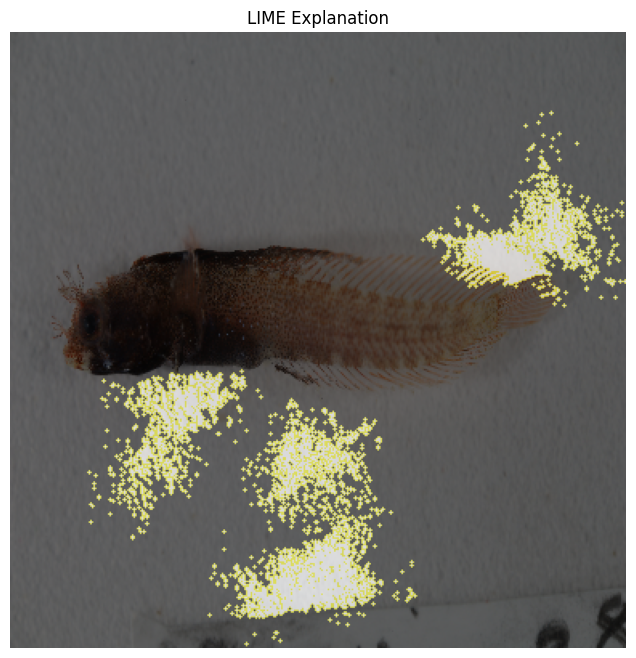

In [6]:
ai.plot_lime_results(lime_map, figure_size=(8, 8), num_features=5)

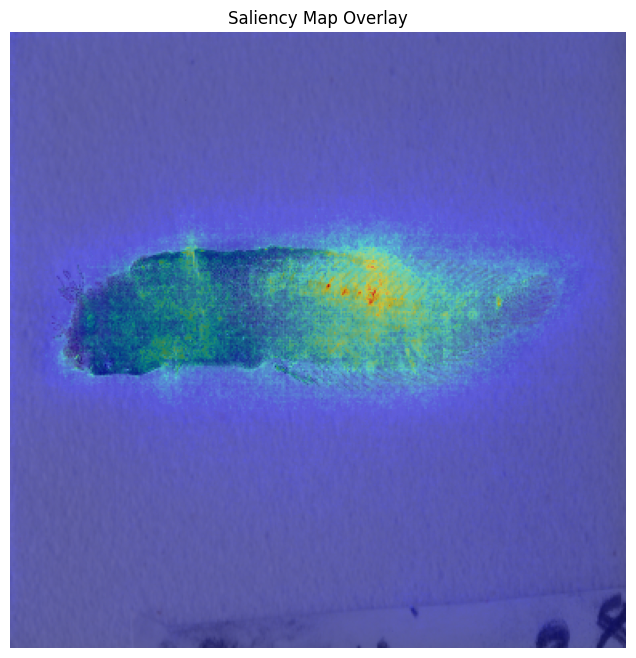

In [7]:
ai.plot_saliency_overlay((slcy_map), (8, 8))

In [1]:
from tensorflow.keras.applications import vit
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, Concatenate, GlobalAveragePooling1D
from tensorflow.keras.models import Model

# Vision Transformer (ViT) as Backbone
vit_base = vit.ViT_B16(
    input_shape=(224, 224),
    include_top=False,
    pretrained="imagenet"
)

ImportError: cannot import name 'vit' from 'tensorflow.keras.applications' (/Users/leonardo/miniconda3/envs/cvenv/lib/python3.10/site-packages/keras/_tf_keras/keras/applications/__init__.py)

In [2]:
from rembg import remove
from PIL import Image

input_path = '/Users/leonardo/Library/CloudStorage/Box-Box/CryptoVision/Data/fish_functions/Species_v02/Tripterygiidae_Enneanectes_matador/lab_Enneanectes_matador_0001.jpeg'
output_path = '/Users/leonardo/Library/CloudStorage/Box-Box/CryptoVision/Data/fish_functions/output.jpeg'

input = Image.open(input_path)
output = remove(input)
output.save(output_path)

OSError: cannot write mode RGBA as JPEG

In [7]:
from pathlib import Path
from rembg import remove, new_session

session = new_session()

for file in Path('/Users/leonardo/Library/CloudStorage/Box-Box/CryptoVision/Data/fish_functions/Species_v02/Apogonidae_Apogon_maculatus').glob('*.jpeg'):
    input_path = str(file)
    output_path = str(file.parent / (file.stem + ".out.png"))

    with open(input_path, 'rb') as i:
        with open(output_path, 'wb') as o:
            input = i.read()
            output = remove(input, session=session, bgcolor=(0, 0, 0, 255))
            o.write(output)

In [9]:
import cv2
import numpy as np

def detect_background(image_path, threshold=200, border_size=10):
    """
    Detect if the background of an image is predominantly white or black.

    Args:
    - image_path (str): Path to the image file.
    - threshold (int): Pixel intensity threshold (above = white, below = black).
    - border_size (int): Width of the border to sample pixels from.

    Returns:
    - str: "white" or "black" depending on the background.
    """
    # Read image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Could not read the image. Check the file path.")
    
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Extract border regions and flatten them
    top_border = gray[:border_size, :].flatten()  # Flatten top
    bottom_border = gray[-border_size:, :].flatten()  # Flatten bottom
    left_border = gray[:, :border_size].flatten()  # Flatten left
    right_border = gray[:, -border_size:].flatten()  # Flatten right
    
    # Concatenate all border pixels
    border_pixels = np.concatenate([top_border, bottom_border, left_border, right_border])
    
    # Count white and black pixels
    white_pixels = np.sum(border_pixels > threshold)
    black_pixels = np.sum(border_pixels <= threshold)
    
    # Decision
    if white_pixels > black_pixels:
        return "white"
    else:
        return "black"


In [14]:

# Example Usage
image_path = '/Users/leonardo/Library/CloudStorage/Box-Box/CryptoVision/Data/fish_functions/Species_v02/Gobiidae_Priolepis_semidoliatus/lab_Priolepis_semidoliatus_0092.jpeg'
result = detect_background(image_path)
print(f"The image background is predominantly {result}.")


The image background is predominantly black.


: 

In [4]:
import os
from rembg import remove
from PIL import Image
import argparse
from tqdm import tqdm
import cv2
import numpy as np

image_path = '/Users/leonardo/Library/CloudStorage/Box-Box/CryptoVision/Data/fish_functions/Species_v02/Gobiidae_Priolepis_semidoliatus/lab_Priolepis_semidoliatus_0092.jpeg'

img = Image.open(image_path)

width, height = img.size
img_resized = img.resize((width // 4, height // 4))

img_resized.save('/Users/leonardo/Library/CloudStorage/Box-Box/CryptoVision/Data/fish_functions/lab_Priolepis_semidoliatus_0092_resized.jpeg')

In [2]:
import os
import shutil

source_dir = "/Volumes/T7_shield/CryptoVision/Data/others/jeannot_photos"

for folder in os.listdir("/Volumes/T7_shield/CryptoVision/Data/others/jeannot_photos"):
    
    if folder == "all" or folder.startswith("."):
        continue
    
    folder_path = os.path.join(source_dir, folder)
    
    for image in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image)
        new_image_path = os.path.join(source_dir, 'all', image)
        
        shutil.copy(image_path, new_image_path)

NotADirectoryError: [Errno 20] Not a directory: '/Volumes/T7_shield/CryptoVision/Data/others/jeannot_photos/Seychelles_Species_data_from_Laura-Li.xlsx'

In [23]:
import os
import random
from pptx import Presentation
from pptx.util import Inches, Pt

def create_ppt_from_images(base_directory, output_ppt):
    """
    Create a PowerPoint presentation with images from subfolders.

    Each slide will have the subfolder's name as the title, and up to 36 randomly selected images from the subfolder.

    :param base_directory: Path to the directory containing subfolders with images.
    :param output_ppt: Path to save the generated PowerPoint file.
    """
    # Create a PowerPoint presentation object
    presentation = Presentation()

    # Set slide size to 16:9
    presentation.slide_width = Inches(13.33)
    presentation.slide_height = Inches(7.5)

    # Sort subfolders alphabetically
    subfolders = sorted(os.listdir(base_directory))

    # Iterate through all subfolders in the base directory
    for subfolder in subfolders:
        subfolder_path = os.path.join(base_directory, subfolder)

        # Check if it's a directory
        if os.path.isdir(subfolder_path):
            # Get all image files in the subfolder
            images = [
                os.path.join(subfolder_path, f)
                for f in os.listdir(subfolder_path)
                if f.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".gif"))
            ]

            if not images:
                continue  # Skip if no images are found

            # Randomly select up to 36 images
            selected_images = random.sample(images, min(len(images), 36))

            # Add a slide for the subfolder
            slide = presentation.slides.add_slide(presentation.slide_layouts[5])

            # Set the title of the slide to the subfolder name
            title = slide.shapes.title
            if title:
                title.text = subfolder
                title.text_frame.text = subfolder
                title.text_frame.paragraphs[0].alignment = 1  # Center align the title
                for paragraph in title.text_frame.paragraphs:
                    for run in paragraph.runs:
                        run.font.size = Pt(18)  # Reduce title font size

            # Add images to the slide
            slide_width = Inches(13.33)
            slide_height = Inches(7.5)

            left_margin = Inches(0.5)
            top_margin = Inches(1.5)

            grid_columns = 6
            grid_rows = 6

            image_width = (slide_width - 2 * left_margin) / grid_columns - Inches(0.1)
            image_height = (slide_height - top_margin - Inches(0.5)) / grid_rows - Inches(0.1)

            col_offset = (slide_width - (grid_columns * (image_width + Inches(0.1)))) / 2

            left = col_offset
            top = top_margin

            for index, image_path in enumerate(selected_images):
                if index % grid_columns == 0 and index != 0:
                    # Move to the next row
                    top += image_height + Inches(0.1)
                    left = col_offset  # Reset left position

                # Add image while preserving aspect ratio
                img = slide.shapes.add_picture(image_path, left, top)
                original_width = img.width
                original_height = img.height

                # Calculate scaling factor to fit within grid cell while preserving aspect ratio
                scale_x = image_width / original_width
                scale_y = image_height / original_height
                scale = min(scale_x, scale_y)

                # Resize image
                img.width = int(original_width * scale)
                img.height = int(original_height * scale)

                # Center the image in the grid cell
                img.left = int(left + (image_width - img.width) / 2)
                img.top = int(top + (image_height - img.height) / 2)

                left += image_width + Inches(0.1)  # Move to the next column

    # Save the PowerPoint presentation
    presentation.save(output_ppt)
    print(f"PowerPoint presentation saved to {output_ppt}")

# Example usage:
# Replace 'your_directory_path' with the path to the directory containing subfolders with images
# Replace 'output_presentation.pptx' with the desired output path
# create_ppt_from_images("your_directory_path", "output_presentation.pptx")




 
create_ppt_from_images("/Users/leonardo/Library/CloudStorage/Box-Box/CryptoVision/Data/fish_functions/Species_v02", "species_v3_catalog.pptx")


PowerPoint presentation saved to species_v3_catalog.pptx


In [17]:
from cryptovision.tools import (
    TQDMProgressBar, image_directory_to_pandas, 
    split_image_dataframe, tf_dataset_from_pandas
)

import pandas as pd

SEED = 42


df_lab = image_directory_to_pandas(
        "/Users/leonardo/Library/CloudStorage/Box-Box/CryptoVision/Data/fish_functions/Species_v03")
df_web = image_directory_to_pandas(
    "/Users/leonardo/Library/CloudStorage/Box-Box/CryptoVision/Data/web/Species_v01")
df_inatlist = image_directory_to_pandas(
    "/Users/leonardo/Library/CloudStorage/Box-Box/CryptoVision/Data/inaturalist/Species_v02")
df_chris = image_directory_to_pandas(
    "/Volumes/T7_shield/CryptoVision/Data/others/hemingson_photos/others_organized/Species"
)
df_chris_lirs = image_directory_to_pandas(
    "/Volumes/T7_shield/CryptoVision/Data/others/hemingson_photos/LIRS23_organized/Species"
)
df_ll = image_directory_to_pandas(
    "/Volumes/T7_shield/CryptoVision/Data/others/jeannot_photos/cv_organized/03_Species"
)


In [18]:
df = pd.concat([df_lab, df_web, df_inatlist, df_chris, df_chris_lirs, df_ll], ignore_index=True, axis=0)

df.head(10)

,image_path,folder_label,family,genus,species
0,/Users/leonardo/Library/CloudStorage/Box-Box/C...,Pomacentridae_Chromis_iomelas,Pomacentridae,Chromis,Chromis iomelas
1,/Users/leonardo/Library/CloudStorage/Box-Box/C...,Pomacentridae_Chromis_iomelas,Pomacentridae,Chromis,Chromis iomelas
2,/Users/leonardo/Library/CloudStorage/Box-Box/C...,Pomacentridae_Chromis_iomelas,Pomacentridae,Chromis,Chromis iomelas
3,/Users/leonardo/Library/CloudStorage/Box-Box/C...,Pomacentridae_Chromis_iomelas,Pomacentridae,Chromis,Chromis iomelas
4,/Users/leonardo/Library/CloudStorage/Box-Box/C...,Pomacentridae_Chromis_iomelas,Pomacentridae,Chromis,Chromis iomelas
5,/Users/leonardo/Library/CloudStorage/Box-Box/C...,Pomacentridae_Chromis_iomelas,Pomacentridae,Chromis,Chromis iomelas
6,/Users/leonardo/Library/CloudStorage/Box-Box/C...,Pomacentridae_Chromis_iomelas,Pomacentridae,Chromis,Chromis iomelas
7,/Users/leonardo/Library/CloudStorage/Box-Box/C...,Pomacentridae_Chromis_iomelas,Pomacentridae,Chromis,Chromis iomelas
8,/Users/leonardo/Library/CloudStorage/Box-Box/C...,Pomacentridae_Chromis_iomelas,Pomacentridae,Chromis,Chromis iomelas
9,/Users/leonardo/Library/CloudStorage/Box-Box/C...,Pomacentridae_Chromis_iomelas,Pomacentridae,Chromis,Chromis iomelas


In [19]:
df.shape

(20841, 5)

In [20]:

df = pd.concat([df_lab, df_web, df_inatlist, df_chris, df_chris_lirs, df_ll], ignore_index=True, axis=0)


counts = df['species'].value_counts()
df = df[df['species'].isin(counts[counts > 99].index)]
df.shape

(17908, 5)

In [13]:
df['family'].value_counts()

family
Gobiidae           6154
Labridae           1611
Pomacentridae      1281
Apogonidae         1241
Tripterygiidae     1083
Blenniidae          852
Syngnathidae        801
Pomacanthidae       786
Scorpaenidae        642
Tetraodontidae      629
Pseudochromidae     541
Chaetodontidae      516
Cirrhitidae         504
Chaenopsidae        423
Serranidae          258
Plesiopidae         217
Scorpaenidea        199
Creediidae          101
Gobbidae             67
Bleniidae             1
Bythitidae            1
Name: count, dtype: int64

In [21]:

train_df, val_df, test_df = split_image_dataframe(
    df, 
    test_size=0.7, 
    val_size=0.15, 
    stratify_by='folder_label',
    random_state=SEED
)

In [22]:
df['species'].nunique()

64

In [6]:
import cv2

image_path = '/Volumes/T7_shield/CryptoVision/Data/web/Species_v02/Apogonidae_Pristiapogon_kallopterus/web_Pristiapogon_kallopterus_0021.jpeg'

img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

clahe_image = clahe.apply(img)

clahe_image

array([[ 68,  58,  66, ...,  68,  74,  71],
       [ 48,  53,  66, ...,  57,  63,  63],
       [ 50,  53,  63, ...,  49,  54,  57],
       ...,
       [132, 129, 134, ..., 169, 164, 164],
       [140, 148, 140, ..., 167, 161, 161],
       [148, 156, 148, ..., 159, 156, 156]], dtype=uint8)

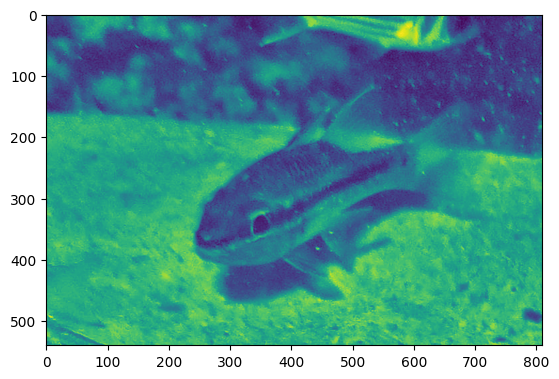

In [3]:
import matplotlib.pyplot as plt

plt.imshow(clahe_image)

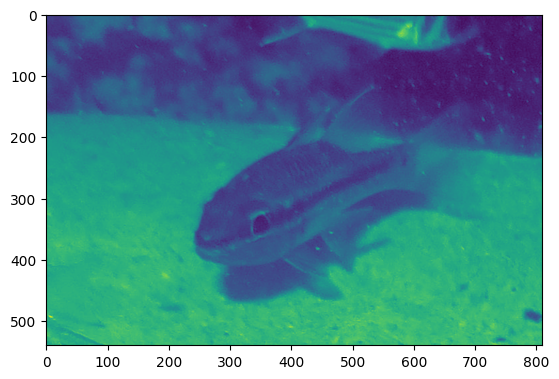

In [4]:
plt.imshow(img)